#Multi Agent for Academic Books
Made by: Wilfredo Aaron Sosa Ramos

In [2]:
!pip install -q langchain langchain_core langchain_community langgraph langchain_google_genai

In [3]:
import os
from google.colab import userdata

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_if_undefined("SERPER_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")
_set_if_undefined("ASSEMBLYAI_API_KEY")

In [4]:
!pip install -q chroma langchain_chroma pypdf assemblyai

In [5]:
import tempfile
import uuid
import requests

class FileHandler:
    def __init__(self, file_loader, file_extension):
        self.file_loader = file_loader
        self.file_extension = file_extension

    def load(self, url):
        # Generate a unique filename with a UUID prefix
        unique_filename = f"{uuid.uuid4()}.{self.file_extension}"

        try:
            # Download the file from the URL and save it to a temporary file
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Raise an HTTPError for bad responses

            with tempfile.NamedTemporaryFile(delete=False, prefix=unique_filename) as temp_file:
                temp_file.write(response.content)
                temp_file_path = temp_file.name

        except requests.exceptions.RequestException as req_err:
            raise Exception(f"Failed to download file from URL", url) from req_err
        except Exception as e:
            raise Exception(f"Failed to handle file download", url) from e

        # Use the file_loader to load the documents
        try:
            loader = self.file_loader(file_path=temp_file_path)
        except Exception as e:
            raise Exception(f"No file found", temp_file_path) from e

        try:
            documents = loader.load()
        except Exception as e:
            raise Exception(f"No file content available", temp_file_path) from e

        # Remove the temporary file
        os.remove(temp_file_path)

        return documents

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import AssemblyAIAudioTranscriptLoader

In [7]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100
)

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm_for_img = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [32]:
def return_context_from_rag(split_docs, query):
  vectorstore = Chroma.from_documents(
      documents=split_docs,
      collection_name="rag",
      embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001"),
  )

  retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4},
  )

  context = retriever.invoke(query)

  vectorstore.delete_collection()
  del retriever
  del vectorstore

  return context

In [33]:
from langchain_community.vectorstores.utils import filter_complex_metadata
from typing import Annotated
from langchain_core.tools import tool

@tool
def pdf_rag_tool(
    pdf_url: Annotated[str, "The URL of the PDF document to process."],
    query: Annotated[str, "The query or question to retrieve context for."]
):
    """Use this tool to process a PDF document and retrieve context based on a query."""
    try:
        pdf_loader = FileHandler(PyPDFLoader, "pdf")
        docs = pdf_loader.load(pdf_url)

        if not docs:
            return "No documents found in the provided PDF."

        split_docs = splitter.split_documents(docs)
        print(f"PDF documents - Docs' length: {len(split_docs)}")
        context = return_context_from_rag(split_docs, query)
        return context

    except Exception as e:
        return f"Failed to process the PDF. Error: {repr(e)}"


@tool
def img_rag_tool(
    img_url: Annotated[str, "The URL of the image to process."],
    query: Annotated[str, "The query or question to retrieve context for."]
):
    """Use this tool to analyze an image (e.g., a book cover or academic content) and retrieve context based on a query."""
    try:
        message = HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Give me a summary of what you see in the image. It must be 3 detailed paragraphs about the book or academic knowledge.",
                },
                {"type": "image_url", "image_url": img_url},
            ]
        )

        response = llm_for_img.invoke([message]).content
        print(f"Generated summary: {response}")

        docs = Document(page_content=response, metadata={"source": img_url})
        split_docs = splitter.split_documents([docs])
        print(f"Image documents - Docs' length: {len(split_docs)}")

        context = return_context_from_rag(split_docs, query)
        return context

    except Exception as e:
        return f"Failed to process the image. Error: {repr(e)}"


@tool
def audio_rag_tool(
    audio_url: Annotated[str, "The URL of the audio file to process."],
    query: Annotated[str, "The query or question to retrieve context for."]
):
    """Use this tool to process an audio file and retrieve context based on a query."""
    try:
        audio_loader = FileHandler(AssemblyAIAudioTranscriptLoader, "mp3")
        docs = audio_loader.load(audio_url)

        if not docs:
            return "No documents found in the provided audio file."

        split_docs = splitter.split_documents(docs)
        print(f"Audio documents - Docs' length: {len(split_docs)}")

        context = return_context_from_rag(filter_complex_metadata(split_docs), query)
        return context

    except Exception as e:
        return f"Failed to process the audio file. Error: {repr(e)}"

In [12]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import GoogleSerperAPIWrapper

@tool
def serper_tool(
    query: Annotated[str, "The search query for retrieving intermediate answers."]
):
    """Use this to perform a search query using the Google Serper API.
    Provide a concise query to retrieve relevant information."""
    try:
        search = GoogleSerperAPIWrapper()
        result = search.run(query)
    except BaseException as e:
        return f"Failed to execute search. Error: {repr(e)}"

    result_str = f"Successfully executed search:\nQuery: {query}\nResult: {result}"
    return (
        result_str
    )

In [13]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a specialized AI assistant focused on researching, analyzing, and summarizing knowledge from books and academic literature. "
        "Your goal is to collaborate with tools and other assistants to locate and process information using APIs such as SerperAPI. "
        "Retrieve accurate, well-cited information, and ensure your findings are relevant and trustworthy. "
        "Deliver the following outputs: "
        "- Critical summaries of the content, emphasizing key concepts, insights, and implications. "
        "- Valid URLs or references to original sources, where applicable. "
        "If you are unable to retrieve complete information, document your progress and provide sufficient context so another assistant can continue the task seamlessly. "
        "When all deliverables are complete, prefix your response with 'FINAL ANSWER' to signal the task is finalized and ready for review."
        f"\n{suffix}"
    )

In [14]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [15]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

def get_next_node(last_message: BaseMessage, goto: str):
    if goto == "FINAL ANSWER":
        # Any agent decided the work is done
        return END
    return goto

In [34]:
# PDF RAG Agent
pdf_rag_agent = create_react_agent(
    llm,
    tools=[pdf_rag_tool],
    state_modifier=make_system_prompt(
        """You are an expert in processing PDF documents to extract and analyze academic knowledge.
        Your goal is to provide concise, accurate, and contextually relevant summaries based on the query.
        Utilize the PDF RAG tool to retrieve and analyze content, ensuring valid and reliable outputs."""
    )
)

# IMG RAG Agent
img_rag_agent = create_react_agent(
    llm,
    tools=[img_rag_tool],
    state_modifier=make_system_prompt(
        """You are an expert in analyzing images to extract academic knowledge or book-related details.
        Your goal is to generate detailed summaries and relevant insights based on the visual content of the image.
        Use the IMG RAG tool to process the image and provide accurate and trustworthy results."""
    )
)

# AUDIO RAG Agent
audio_rag_agent = create_react_agent(
    llm,
    tools=[audio_rag_tool],
    state_modifier=make_system_prompt(
        """You are an expert in processing audio files to extract academic knowledge and key insights.
        Your goal is to provide concise and accurate summaries based on the content of the audio file.
        Use the AUDIO RAG tool to analyze the audio and ensure the outputs are detailed and reliable."""
    )
)

# SERPER RESEARCH Agent
serper_research_agent = create_react_agent(
    llm,
    tools=[serper_tool],
    state_modifier = make_system_prompt(
        """You are an expert in retrieving and analyzing knowledge from books and academic literature.
        Your goal is to locate real, reliable information and provide valid references or URLs, when applicable,
        based on a given research topic. Utilize APIs like SerperAPI to ensure accurate and trustworthy results.
        Deliver critical summaries and ensure your findings are presented in a clear and concise manner."""
    )
)

In [17]:
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

def router_node(
    state: MessagesState,
) -> Command[Literal["pdf_rag_node", "img_rag_node", "audio_rag_node", "web_search_node"]]:

    messages = [
        SystemMessage(
            content=(
                "You are a routing assistant designed to determine the best processing method for a user's query. "
                "Your task is to decide whether the query involves processing a PDF, an image, an audio file, or if it requires retrieving information from the web. "
                "Route the query to the most suitable system: PDF RAG, IMG RAG, AUDIO RAG, or Web Search."
            )
        ),
        HumanMessage(
            content=f"""
            Based on the following query, determine the most suitable processing method:

            Query: {state['messages'][-1].content}

            Criteria for routing:
            1. Route to **PDF RAG** if the query involves extracting or analyzing content from a PDF document, such as a research paper or book.
            2. Route to **IMG RAG** if the query involves analyzing visual content from an image, such as a book cover, diagram, or handwritten notes.
            3. Route to **AUDIO RAG** if the query involves processing an audio file, such as a podcast, recorded lecture, or audiobook.
            4. Route to **Web Search** if the query requires retrieving information from the web, such as academic knowledge, books, or general information.

            Return only the routing decision: `pdf_rag_node`, `img_rag_node`, `audio_rag_node`, or `web_search_node`.
            """
        )
    ]

    result = llm.invoke(messages)

    decision = result.content.strip()

    goto = get_next_node(result, decision)

    result = HumanMessage(
        content=decision, name="router"
    )

    print(f"ROUTE NODE: {decision}")

    return Command(
        update={
            "messages": result,
        },
        goto=goto,
    )

In [35]:
def info_search_node(state: MessagesState, agent_name: str, agent) -> Command[Literal["format_results"]]:
    """
    A generic node handler for research agents to avoid repetition and improve maintainability.

    Args:
        state: The current state of the messages.
        agent: The research agent's `invoke` method.
        agent_name: The name of the research agent (e.g., "tavily", "serper").

    Returns:
        A Command object with updated messages and the next node to transition to.
    """
    result = agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "format_results")

    # Update the last message with the agent's name
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name=agent_name
    )

    print(f"INFO. SEARCH NODE - {agent_name}: {result['messages'][-1].content}")

    return Command(
        update={
            "messages": result["messages"],  # Share internal message history with other agents
        },
        goto=goto,
    )

def pdf_rag_node(state: MessagesState) -> Command[Literal["format_results"]]:
    return info_search_node(state, "pdf_rag", pdf_rag_agent)

def img_rag_node(state: MessagesState) -> Command[Literal["format_results"]]:
    return info_search_node(state, "img_rag", img_rag_agent)

def audio_rag_node(state: MessagesState) -> Command[Literal["format_results"]]:
    return info_search_node(state, "audio_rag", audio_rag_agent)

def web_search_node(state: MessagesState) -> Command[Literal["format_results"]]:
    return info_search_node(state, "web_search", serper_research_agent)

In [19]:
from pydantic import BaseModel, Field, validator

class AnswerSchema(BaseModel):
    summary: str = Field(..., description="A concise and high-level summary of the answer to the question.")
    detailed_explanation: str = Field(
        ...,
        description="An in-depth explanation, including analysis, reasoning, and supporting evidence."
    )
    key_takeaways: list[str] = Field(
        ...,
        description="A list of actionable or significant points derived from the research."
    )

class QAResearchResult(BaseModel):
    question: str = Field(..., description="The research question or query provided by the user.")
    answer: AnswerSchema = Field(..., description="A structured response to the research question, divided into components.")
    topic: str = Field(..., description="The broader academic topic or context related to the question.")
    sources: list[str] = Field(
        ...,
        min_items=1,
        description="A non-empty list of references or titles of the books, papers, or resources used to answer the question. Must have at least one value."
    )
    source_urls: list[str] = Field(
        ...,
        min_items=1,
        description="A non-empty list of real and valid URLs pointing to the resources used for the answer. Must have at least one value."
    )
    detailed_analysis: str = Field(
        ...,
        description="A comprehensive analysis of the resources, including their methodology, key findings, and implications."
    )
    related_keywords: list[str] = Field(
        ...,
        description="A list of relevant keywords or topics extracted from the question and the analyzed resources."
    )
    confidence_score: float = Field(
        ...,
        description="The confidence score of the provided answer, ranging from 0 to 1."
    )
    tools_used: list[str] = Field(
        ...,
        description="A list of tools or APIs used to retrieve, analyze, or synthesize the information."
    )
    citation_format: str = Field(
        ...,
        description="The format used for citations (e.g., APA, MLA, Chicago)."
    )
    citations: list[str] = Field(
        ...,
        description="A list of citations for the resources used, formatted according to the specified citation format."
    )
    retrieval_date: str = Field(
        ...,
        description="The date when the information was retrieved in YYYY-MM-DD format."
    )
    response_time: float = Field(
        ...,
        description="The time taken to generate the response, in seconds."
    )

    @validator("sources", "source_urls")
    def must_have_min_items(cls, value):
        if len(value) < 1:
            raise ValueError("This field must have at least one value.")
        return value


<ipython-input-19-b791fed866f0>:61: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @validator("sources", "source_urls")


In [20]:
from langchain_core.output_parsers import JsonOutputParser

def format_results(state: MessagesState) -> Command[Literal[END]]:
    json_parser = JsonOutputParser(pydantic_object=QAResearchResult)

    messages = [
        SystemMessage(
            content=(
                "You are a QA-focused AI assistant tasked with answering questions based on real information retrieved from the web. "
                "Your responses must adhere to the `QAResearchResult` schema and provide accurate, structured, and well-cited information. "
                "Ensure that the `sources` and `source_urls` fields in your response are non-empty, valid, and reliable."
            )
        ),
        HumanMessage(
            content=f"""Answer the following question based on the retrieved information and format the response using the `QAResearchResult` schema:

            Question: {state['messages'][0].content}
            Context: {state['messages'][-1].content}

            Ensure your response adheres to the following schema fields:
            - `question`: The original question asked by the user.
            - `answer`: A structured response that includes:
                - `summary`: A concise, high-level summary of the answer.
                - `detailed_explanation`: A thorough explanation based on the retrieved information.
                - `key_takeaways`: A list of actionable or significant points derived from the answer.
            - `topic`: The broader academic topic or context related to the question.
            - `sources`: A non-empty list of references or titles of the books, papers, or resources used to answer the question.
            - `source_urls`: A non-empty list of real and valid URLs pointing to the resources used for the answer.
            - `detailed_analysis`: A comprehensive analysis of the sources used, including methodology, key findings, and implications.
            - `related_keywords`: A list of relevant keywords or topics extracted from the question and the analyzed resources.
            - `confidence_score`: A score between 0 and 1 indicating the confidence level of the answer.
            - `tools_used`: A list of tools or APIs utilized to retrieve and analyze the information.
            - `citation_format`: The format used for citations (e.g., APA, MLA, Chicago).
            - `citations`: A list of properly formatted citations for the resources used.
            - `retrieval_date`: The date when the information was retrieved (YYYY-MM-DD).
            - `response_time`: The time taken to generate the response, in seconds.

            You must respond in the language of the user's question.

            Use the following JSON format for your response:
            {json_parser.get_format_instructions()}
            """
        )
    ]

    result = llm.invoke(messages)
    goto = get_next_node(result, "FINAL ANSWER")

    # Update the last message with the agent's name
    result = HumanMessage(
        content=result.content, name="format_results"
    )

    print(f"FORMAT RESULT: {result.content}")

    return Command(
        update={
            "messages": result,
        },
        goto=goto,
    )

In [36]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("router_node", router_node)
workflow.add_node("pdf_rag_node", pdf_rag_node)
workflow.add_node("img_rag_node", img_rag_node)
workflow.add_node("audio_rag_node", audio_rag_node)
workflow.add_node("web_search_node", web_search_node)
workflow.add_node("format_results", format_results)

workflow.add_edge(START, "router_node")
graph = workflow.compile()

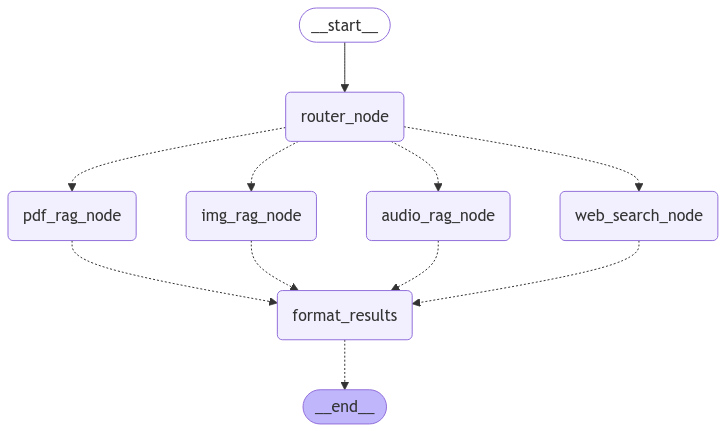

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "What are the insights from the LLM Engineer's Handbook Book?"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: web_search_node
{'router_node': {'messages': HumanMessage(content='web_search_node', additional_kwargs={}, response_metadata={}, name='router', id='45ea8a52-664d-4570-b1c3-58fcd6b4c40a')}}
----
INFO. SEARCH NODE - web_search: The "LLM Engineer's Handbook" provides practical insights into designing, training, and deploying Large Language Models (LLMs) in real-world scenarios. It emphasizes the use of MLOps best practices throughout the LLM lifecycle. The book covers a broad range of topics, including the fundamentals of LLMs, their internal workings, and advanced applications. It also delves into practical aspects such as training, fine-tuning, RAG (Retrieval-Augmented Generation), and evaluation strategies. The book appears to be a comprehensive guide, suitable for both beginners and those looking to enhance their understanding of LLMs and their deployment. However, it is noted that for a deeper understanding of the internal mechanisms of LLMs, other specialized books may b

In [29]:
json_parser = JsonOutputParser(pydantic_object=QAResearchResult)
json_parser.parse(s['format_results']['messages'].content)

{'question': "What are the insights from the LLM Engineer's Handbook Book?",
 'answer': {'summary': 'The "LLM Engineer\'s Handbook" provides practical guidance on designing, training, and deploying Large Language Models (LLMs) using MLOps best practices. It covers a wide array of topics from LLM fundamentals to advanced applications, including training, fine-tuning, RAG, and evaluation strategies.',
  'detailed_explanation': 'The handbook serves as a comprehensive guide for those involved in the LLM lifecycle, focusing on real-world application and deployment. It delves into the practical aspects of working with LLMs, such as training and fine-tuning, and explores advanced techniques like Retrieval-Augmented Generation (RAG). The book emphasizes the importance of MLOps throughout the process, providing a structured approach to LLM development. While it provides a good understanding of the practical aspects, it acknowledges that for a deeper dive into the internal workings of LLMs, othe

In [30]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "¿Cuáles son los puntos más importantes del libro '¿Cómo hacer una tesis?' de Humberto Eco?"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: web_search_node
{'router_node': {'messages': HumanMessage(content='web_search_node', additional_kwargs={}, response_metadata={}, name='router', id='6d5079b5-2883-421c-b08c-54bed26e6232')}}
----
INFO. SEARCH NODE - web_search: Based on the search results, here are some key points from Umberto Eco's "How to Write a Thesis":

*   **You are not Proust:** This emphasizes the need for clear, concise writing, avoiding overly complex or flowery language. The focus should be on clarity and directness.
*   **You are not e. e. cummings:** Similar to the first point, this stresses the importance of adhering to standard writing conventions, avoiding unconventional formatting or stylistic choices that could hinder understanding.
*   **Begin new paragraphs often:** This suggests that breaking up text into smaller, more digestible paragraphs enhances readability and helps maintain the reader's focus.
*  **Write everything that comes into your head, but only in the first draft:** This encou

In [45]:
import chromadb

chromadb.api.client.SharedSystemClient.clear_system_cache()

In [40]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "¿De qué trata este Paper? Es un PDF: https://www.scielo.org.mx/pdf/ap/v39n2/2448-735X-ap-39-02-7.pdf"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: pdf_rag_node
{'router_node': {'messages': HumanMessage(content='pdf_rag_node', additional_kwargs={}, response_metadata={}, name='router', id='77816cee-9ed4-4229-8b75-77869bf017ad')}}
----
PDF documents - Docs' length: 9
INFO. SEARCH NODE - pdf_rag: El documento es un análisis del libro "Kant y el ornitorrinco" de Umberto Eco. El autor del análisis explora cómo Eco aborda la noción de significado a través de la revisión de cinco paradigmas semánticos. Eco plantea si la semántica puede ser una disciplina unitaria, considerando las investigaciones sobre el significado y el sentido. El texto también menciona cómo Eco busca una noción contractual tanto del significado como de la referencia, fusionando semántica y pragmática, y concluyendo en un "realismo contractual" donde la experiencia limita las interpretaciones. Además, se destaca que el texto mantiene marcas de oralidad presentes en las conferencias de Eco.
{'pdf_rag_node': {'messages': [HumanMessage(content='¿De qué trata 

In [42]:
json_parser = JsonOutputParser(pydantic_object=QAResearchResult)
json_parser.parse(s['format_results']['messages'].content)

{'question': '¿De qué trata este Paper? Es un PDF: https://www.scielo.org.mx/pdf/ap/v39n2/2448-735X-ap-39-02-7.pdf',
 'answer': {'summary': 'El paper es un análisis del libro "Kant y el ornitorrinco" de Umberto Eco. Explora cómo Eco aborda la noción de significado a través de cinco paradigmas semánticos, la posibilidad de una semántica unitaria, y la búsqueda de una noción contractual del significado y la referencia, culminando en un "realismo contractual".',
  'detailed_explanation': 'El documento analiza el libro "Kant y el ornitorrinco" de Umberto Eco, centrándose en cómo Eco aborda el problema del significado. El autor del análisis examina la revisión que hace Eco de cinco paradigmas semánticos para determinar si la semántica puede ser una disciplina unificada. Eco investiga el significado y el sentido, y propone una noción contractual tanto del significado como de la referencia, fusionando semántica y pragmática. Esta fusión concluye en un "realismo contractual", donde la experien

In [43]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                """
                Bríndame libros que hablen sobre esta arquitectura de IA: https://heidloff.net/assets/img/2023/02/transformers.png
                """
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: img_rag_node
{'router_node': {'messages': HumanMessage(content='img_rag_node', additional_kwargs={}, response_metadata={}, name='router', id='a6315cc6-e6f3-4bd4-a650-4ca29b7c6aa8')}}
----
Generated summary: Certainly! Here's a detailed summary of the image, focusing on the academic concepts it represents:

The image provides a visual comparison of the architectures of two prominent Transformer-based models in Natural Language Processing (NLP): BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer). On the left side, we see a depiction of BERT, labeled as an "Encoder," composed of multiple identical layers stacked on top of each other (represented by "Nx"). Each of these layers consists of a "Multi-Head Attention" mechanism, followed by a "Feed Forward" network, with "Add & Norm" layers wrapping around each component. The input to this encoder passes through "Input Embedding" (which converts words or sub-word units into ve

In [46]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                """
                Analiza este audio y bríndame los puntos clave a nivel académico: https://raw.github.com/AaronSosaRamos/mission-flights/main/files-for-test/RAG%20for%20LLMs%20explained%20in%203%20minutes.mp3
                """
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: audio_rag_node
{'router_node': {'messages': HumanMessage(content='audio_rag_node', additional_kwargs={}, response_metadata={}, name='router', id='716c8e78-50ac-499c-88ba-803117157af0')}}
----
Audio documents - Docs' length: 4
INFO. SEARCH NODE - audio_rag: FINAL ANSWER:
Claro, aquí están los puntos clave a nivel académico sobre el audio proporcionado:

**Problemas al implementar LLMs en empresas:**

1.  **Falta de conocimiento del dominio:** Los LLMs se entrenan con datos públicos y carecen de acceso a información específica de la empresa como procedimientos operativos estándar (SOPs) o propiedad intelectual (IP). Esto limita su capacidad para responder preguntas personalizadas al contexto empresarial.
2.  **Alucinaciones:** Los LLMs pueden generar respuestas que parecen creíbles pero son incorrectas, lo que puede llevar a problemas si se confía en ellas.
3.  **Cortes en los datos de entrenamiento:** Los LLMs pueden tener fechas de corte en sus datos de entrenamiento, lo qu

In [47]:
json_parser = JsonOutputParser(pydantic_object=QAResearchResult)
json_parser.parse(s['format_results']['messages'].content)

{'question': 'Analiza este audio y bríndame los puntos clave a nivel académico: https://raw.github.com/AaronSosaRamos/mission-flights/main/files-for-test/RAG%20for%20LLMs%20explained%20in%203%20minutes.mp3',
 'answer': {'summary': 'El audio describe los problemas de implementar LLMs en empresas debido a la falta de conocimiento del dominio, alucinaciones y cortes en los datos de entrenamiento. Propone RAG (Retrieval Augmented Generation) como solución, que mejora las respuestas al añadir información relevante de la empresa al prompt original.',
  'detailed_explanation': "El audio explica que los LLMs (Large Language Models) tienen limitaciones al ser implementados en empresas debido a que carecen de conocimiento específico del dominio, como procedimientos operativos estándar (SOPs) o propiedad intelectual (IP). Esto lleva a respuestas inexactas o 'alucinaciones'. Además, los LLMs pueden tener cortes en los datos de entrenamiento, lo que significa que pueden carecer de información recie